# Workshop 10. Автокодировщик, Генеративно-Состязательные сети


Тетрадка скопирована из https://github.com/spbu-math-cs/ml-course/blob/main/2022-spring-part-2/seminars/04_autoencoder_gan/04_autoencoder_gan.ipynb

Источник вдохновения: https://github.com/andriygav/MachineLearningSeminars/tree/master/sem16

Видео семинара МФТИ https://www.youtube.com/watch?v=wCX-8AiYYzk 

## Библиотеки

In [ ]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
import os
from urllib.request import urlopen
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
from scipy.stats import norm
import torch
import torch.nn.functional as F

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### GAN's для MNIST

#### Полезный код для обучения

In [ ]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    optima_generator, optima_discriminator = optimizer
    
    optima_generator.zero_grad()
    optima_discriminator.zero_grad()
    
    discriminator_loss = model.discriminator_loss(x_batch)
    discriminator_loss.backward()
    optima_discriminator.step()

    optima_generator.zero_grad()
    optima_discriminator.zero_grad()
    
    generator_loss = model.generator_loss(len(x_batch))
    generator_loss.backward()
    optima_generator.step()
    
    return discriminator_loss.cpu().item() + generator_loss.cpu().item()

In [ ]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(model.device), batch_of_y.to(model.device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [ ]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    # здесь главная сложность в ГАНах — подобрать параметры, чтобы сошлось обучение
    optima_generator = optimizer(model.generator.parameters(), lr=lr*10, betas=(0.5, 0.999))
    optima_discriminator = optimizer(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'epoch loss': np.nan})
    for it in iterations:        
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(
            train_generator=batch_generator, 
            model=model, 
            loss_function=loss_function, 
            optimizer=(optima_generator, optima_discriminator), 
            callback=callback)
        
        iterations.set_postfix({'epoch loss': epoch_loss})

#### Модель нейросети

In [ ]:
class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

class GAN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d, D):
        super(type(self), self).__init__()
        self.d = d
        self.discriminator = torch.nn.Sequential(
            Reshape(1, D, D),
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.LeakyReLU(negative_slope=0.2),
            Reshape(-1),
            torch.nn.Linear(in_features=256, out_features=1),
            torch.nn.Sigmoid()
        )
        self.generator = torch.nn.Sequential(
            Reshape(self.d, 1, 1),
            torch.nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias=False),
            Reshape(-1),
            torch.nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        return torch.randn([num_samples, self.d], requires_grad=True).to(self.device)

    def generate_samples(self, num_samples):
        return self.generator(self.generate_noise(num_samples))

    def discriminator_loss(self, batch):
        loss = torch.nn.BCELoss()
        
        batch_size = batch.shape[0]
        
        fake_batch = self.discriminator(self.generate_samples(batch_size).detach())
        real_batch = self.discriminator(batch)
        
        fake_answ = torch.zeros(batch_size, 1).to(self.device)
        real_answ = torch.ones(batch.shape[0], 1).to(self.device)
        
        return 0.5*loss(fake_batch, fake_answ) + 0.5*loss(real_batch, real_answ)

    def generator_loss(self, batch_size):
        loss = torch.nn.BCELoss()
        
        fake_batch = self.discriminator(self.generate_samples(batch_size))
        
        real_answ = torch.ones(batch_size, 1).to(self.device)
            
        return loss(fake_batch, real_answ)
    
    def init_weight(self, mean, std):
        for m in self._modules:
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()


#### Инициализация модели

In [ ]:
loss_function = None
optimizer = torch.optim.Adam

model = GAN(2, 28)
model.to(device)

GAN(
  (discriminator): Sequential(
    (0): Reshape()
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Reshape()
    (11): Linear(in_features=256, out_features=1, bias=True)
    (12): Sigmoid()
  )
  (generator): Sequential(
    (0): Reshape()
    (1): ConvTranspose2d(2, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReL

#### Выборка

In [ ]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

#### Вспомагательные функции

In [ ]:
def show_images(x, digit_size=28):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', interpolation='lanczos')
        plt.axis('off')

In [ ]:
def generate_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(
            model.generate_samples(
                min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0).cpu().detach()

#### Как генерируются данные до обучения

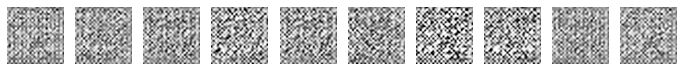

In [ ]:
show_images(generate_samples(model, 10, 10))

#### Обучаем модель

In [ ]:
trainer(count_of_epoch=10, 
        batch_size=64, 
        dataset=MNIST_train,
        model=model, 
        loss_function=loss_function,
        optimizer=optimizer,
        lr = 2e-4,
        callback = None)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#### Как генерируются данные после обучения

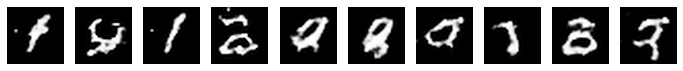

In [ ]:
show_images(generate_samples(model, 10, 50))